In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [2]:
# plotting parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
# load scraped data
df_raw = pd.read_csv('../data/Personal_Movies_Ratings_Features.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   UID                         339 non-null    int64  
 1   My_Rating                   339 non-null    float64
 2   Budget                      329 non-null    object 
 3   Cumulative_Worldwide_Gross  302 non-null    object 
 4   Production_Company1         339 non-null    object 
 5   Synopsis                    331 non-null    object 
 6   Top_250_Rank                75 non-null     float64
 7   Country1                    339 non-null    object 
 8   Director1                   339 non-null    object 
 9   Genre1                      339 non-null    object 
 10  Genre2                      314 non-null    object 
 11  Genre3                      246 non-null    object 
 12  Rating                      339 non-null    float64
 13  Runtime                     339 non

# Preprocess Features

In [4]:
# df_raw.Runtime.describe()
# df_raw.Votes.describe()
# df_raw.Year.describe()
# df_raw.Rating.describe()

In [5]:
feature_columns = ['Runtime', 'Votes', 'Year', 'Rating']

In [6]:
# create feature matrix
X = df_raw.loc[:, feature_columns].values
X.shape

(339, 4)

In [7]:
# binarize my rating
y = (df_raw.My_Rating > 3).astype(int)
y.shape

(339,)

# Split into Train/Test set

In [8]:
np.random.seed(123)

In [9]:
df_test = df_raw.sample(frac=0.1).copy()
train_index = (~df_raw.UID.isin(df_test.UID))
df_train = df_raw.loc[train_index, :].copy()

In [10]:
X_train = X[train_index, :]
X_test = X[~train_index, :]
y_train = y[train_index]
y_test = y[~train_index]

In [11]:
y_train.value_counts()

1    187
0    118
Name: My_Rating, dtype: int64

# Logistic Regression with Cross-Validated Grid Search

In [12]:
# in-sample score with default parameters
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)

0.6163934426229508

In [13]:
# tune parameters with grid-search
parameters = {'class_weight': ['balanced', None], 'C':np.exp(np.arange(-50, 50, 5))}
clf_grid = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, verbose=1)
clf_grid.fit(X_train, y_train);

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.4s finished


In [14]:
# cv results
df_cv_results = pd.DataFrame(clf_grid.cv_results_)
df_cv_results.loc[:, 'param_C_log'] = np.log(df_cv_results.param_C.astype(float))
df_cv_results.loc[:, 'param_class_weight'] = ~df_cv_results.param_class_weight.isnull()
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       40 non-null     float64
 1   std_fit_time        40 non-null     float64
 2   mean_score_time     40 non-null     float64
 3   std_score_time      40 non-null     float64
 4   param_C             40 non-null     object 
 5   param_class_weight  40 non-null     bool   
 6   params              40 non-null     object 
 7   split0_test_score   40 non-null     float64
 8   split1_test_score   40 non-null     float64
 9   split2_test_score   40 non-null     float64
 10  split3_test_score   40 non-null     float64
 11  split4_test_score   40 non-null     float64
 12  split5_test_score   40 non-null     float64
 13  split6_test_score   40 non-null     float64
 14  split7_test_score   40 non-null     float64
 15  split8_test_score   40 non-null     float64
 16  split9_tes

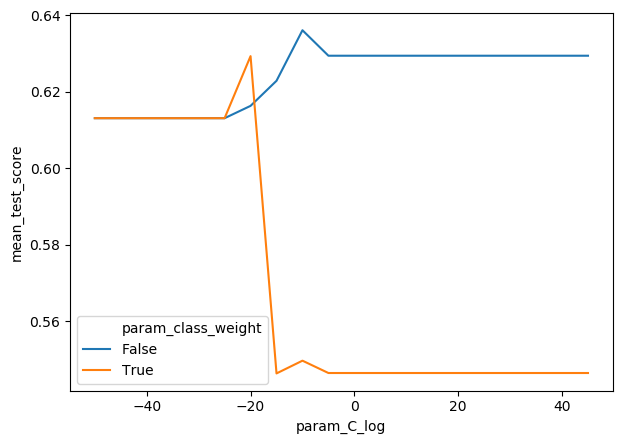

In [15]:
# plot score versus cost, C
sns.lineplot(x='param_C_log', y='mean_test_score', data=df_cv_results, hue='param_class_weight')
plt.show()

In [16]:
# best score with tuned parameters
clf_grid.best_score_

0.6361290322580644

In [17]:
# view predictions of best estimator
df_train.loc[:, 'Predicted_Prob'] = clf_grid.best_estimator_.predict_proba(X_train)[:, 1]

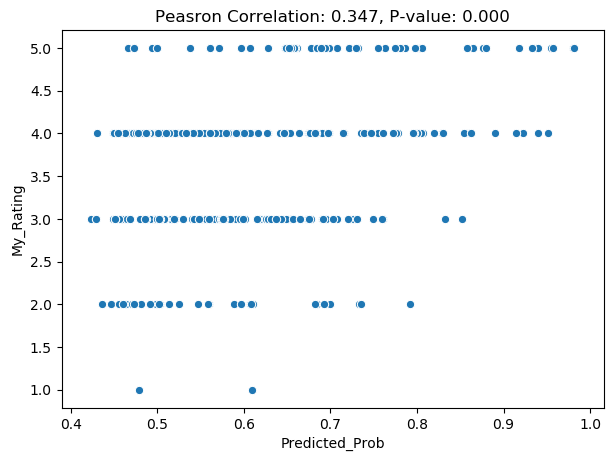

In [18]:
# view correlation with my rating
sns.scatterplot(x='Predicted_Prob', y='My_Rating', data=df_train)
plt.title('Peasron Correlation: %0.3f, P-value: %0.3f' %
          stats.pearsonr(df_train.Predicted_Prob, df_train.My_Rating))
plt.show()

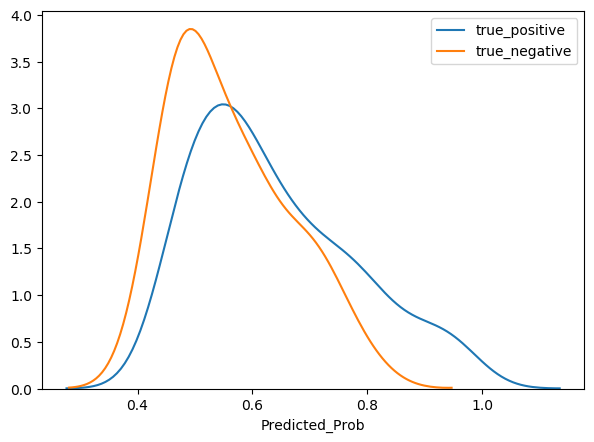

In [19]:
sns.distplot(df_train.Predicted_Prob[df_train.My_Rating>3], hist=False, label='true_positive')
sns.distplot(df_train.Predicted_Prob[df_train.My_Rating<3], hist=False, label='true_negative')
plt.show()

In [20]:
# identify worst predictions that were true negatives
df_train.loc[(y_train==0)&(df_train.Predicted_Prob>0.75), ['Title', 'My_Rating', 'Predicted_Prob']+feature_columns]

,Title,My_Rating,Predicted_Prob,Runtime,Votes,Year,Rating
145,Memento,3.0,0.851423,113,1072090,2000,8.4
181,Titanic,3.0,0.832396,194,999023,1997,7.8
183,Catch Me If You Can,3.0,0.760339,141,769746,2002,8.1
254,Deadpool,2.0,0.791700,108,863287,2016,8.0
316,The Terminator,3.0,0.760038,107,767109,1984,8.0


In [21]:
# identify worst predictions that were true positives
df_train.loc[(y_train==1)&(df_train.Predicted_Prob<0.47), ['Title', 'My_Rating', 'Predicted_Prob']+feature_columns]

,Title,My_Rating,Predicted_Prob,Runtime,Votes,Year,Rating
18,Thunderball,4.0,0.463232,130,99942,1965,7.0
158,Kubo and the Two Strings,4.0,0.466899,101,111855,2016,7.8
160,The Founder,4.0,0.465605,115,109272,2016,7.2
173,Fast Times at Ridgemont High,4.0,0.457145,90,88682,1982,7.2
188,Creep,4.0,0.430205,77,35565,2014,6.3
232,Holes,4.0,0.448763,117,73384,2003,7.0
237,National Lampoon's Animal House,5.0,0.466656,109,108024,1978,7.5
243,The Sandlot,4.0,0.449943,101,74847,1993,7.8
271,Patriot Games,4.0,0.461281,117,98250,1992,6.9
281,My Cousin Vinny,4.0,0.462592,120,100966,1992,7.6


In [22]:
# coefficient of the best estimator
coef = pd.Series(clf_grid.best_estimator_.coef_[0])
coef.index = feature_columns
coef * 10000

Runtime   -0.110429
Votes      0.019534
Year      -1.736032
Rating    -0.002261
dtype: float64

In [23]:
# max coefficient of the best estimator
feature_columns[np.argmax(np.abs(clf_grid.best_estimator_.coef_))]

'Year'

In [24]:
# out-of-sample score with tuned parameters
clf_grid.best_estimator_.score(X_test, y_test)

0.7352941176470589